# League Position Prediction - Template
**Important: Run cells sequentially from top to bottom (Shift+Enter or Run All). Each cell depends on variables created by previous cells.**

This notebook predicts the final league standings for the Ligue 1 season based on Monte Carlo simulations.

## 1. Setup and Configuration

In [6]:
# Import required libraries
import sys
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add parent directory to path so we can import src module
sys.path.insert(0, "..")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 10)

### Load Configuration

Import the configuration file for your league. Configuration files are stored in the `configs/` directory.

In [7]:
# Load configuration for the league
config_file = "../configs/ligue1.yaml"  # Change this to use a different league

with open(config_file, "r") as f:
    config = yaml.safe_load(f)

print(f"League: {config['league']['name']}")
print(f"Country: {config['league']['country']}")
print(f"Season: {config['league']['current_season']}")

League: Ligue 1
Country: France
Season: 2025


## 2. Data Loading and Preparation

Load and prepare match data from the configured sources.

In [8]:
# Import data loading and preprocessing modules
from src.data import (
    load_fixture_csv,
    load_match_statistics,
    normalize_team_names,
    prepare_match_statistics,
)
from src.preprocessing import (
    calculate_home_team_statistics,
    calculate_away_team_statistics,
    calculate_efficiency_metrics,
    calculate_league_table,
)
from src.preprocessing.utils import (
    create_played_matches_dataframe,
    create_remaining_matches_dataframe,
)

# Load fixtures data
fixtures_path = f"../data/raw/{config['data_sources']['all_matches']['filename']}"
fixtures = load_fixture_csv(fixtures_path)

# Normalize team names based on configuration
fixtures = normalize_team_names(fixtures, config.get("team_name_mapping", {}))

print(f"Loaded {len(fixtures)} fixtures")
print(f"Fixtures shape: {fixtures.shape}")
print(f"\nFirst 5 fixtures:")
print(fixtures.head())

Loaded 306 fixtures
Fixtures shape: (306, 7)

First 5 fixtures:
   Match Number  Round Number              Date                Location  \
0             9             1  15/08/2025 18:45            Roazhon Park   
1             4             1  16/08/2025 15:00  Stade Bollaert-Delelis   
2             6             1  16/08/2025 17:00          Stade Louis II   
3             8             1  16/08/2025 19:05         Allianz Riviera   
4             3             1  17/08/2025 13:00    Stade Francis-Le Blé   

           Home Team               Away Team Result  
0   Stade Rennais FC  Olympique de Marseille  1 - 0  
1            RC Lens      Olympique Lyonnais  0 - 1  
2          AS Monaco     Havre Athletic Club  3 - 1  
3           OGC Nice             Toulouse FC  0 - 1  
4  Stade Brestois 29              LOSC Lille  3 - 3  


In [9]:
# Load match statistics
stats_path = f"../data/raw/{config['data_sources']['match_statistics']['filename']}"
statistics = load_match_statistics(stats_path)

# Prepare statistics: standardize columns and normalize team names
statistics = prepare_match_statistics(statistics, config)

print(f"Loaded {len(statistics)} match results")
print(f"Statistics shape: {statistics.shape}")
print(f"\nFirst 5 matches:")
print(statistics.head())

Loaded 180 match results
Statistics shape: (180, 10)

First 5 matches:
         Date          Home Team               Away Team  Home Goals  \
0  15/08/2025   Stade Rennais FC  Olympique de Marseille           1   
1  16/08/2025            RC Lens      Olympique Lyonnais           0   
2  16/08/2025          AS Monaco     Havre Athletic Club           3   
3  16/08/2025           OGC Nice             Toulouse FC           0   
4  17/08/2025  Stade Brestois 29              LOSC Lille           3   

   Away Goals Result  Home Shots  Away Shots  Home Shots on Target  \
0           0      H          12          24                     5   
1           1      A          18          11                     5   
2           1      H          13           9                     3   
3           1      A          13          10                     2   
4           3      D          18          10                     5   

   Away Shots on Target  
0                     2  
1                     3

In [10]:
# Separate played and remaining matches
played_matches = create_played_matches_dataframe(statistics)
remaining_matches = create_remaining_matches_dataframe(fixtures)

print(f"Played matches: {len(played_matches)}")
print(f"Remaining matches: {len(remaining_matches)}")
print(f"\nRemaining matches sample:")
print(remaining_matches.head())

Played matches: 180
Remaining matches: 126

Remaining matches sample:
           Home Team           Away Team
0            FC Metz          LOSC Lille
1            RC Lens    Stade Rennais FC
2  Stade Brestois 29          FC Lorient
3          FC Nantes  Olympique Lyonnais
4           OGC Nice           AS Monaco


## 3. Team Statistics Analysis

Calculate statistics for each team in their home and away performances.

In [11]:
# Calculate home and away team statistics
home_stats = calculate_home_team_statistics(statistics)
away_stats = calculate_away_team_statistics(statistics)

# Calculate efficiency metrics
home_stats, away_stats = calculate_efficiency_metrics(home_stats, away_stats)

print("Home Team Statistics (sorted by attacking efficiency):")
print(
    home_stats.sort_values("home_attack_eff", ascending=False)[
        ["avg_home_goals_scored", "home_attack_eff", "home_defense_eff"]
    ].head(10)
)

Home Team Statistics (sorted by attacking efficiency):
                        avg_home_goals_scored  home_attack_eff  \
Home Team                                                        
Olympique de Marseille               2.700000         0.188811   
FC Lorient                           2.000000         0.157480   
AS Monaco                            2.000000         0.151724   
RC Strasbourg Alsace                 1.700000         0.138211   
Angers SCO                           1.500000         0.133929   
Olympique Lyonnais                   1.700000         0.124088   
Paris Saint-Germain                  2.444444         0.120219   
RC Lens                              1.800000         0.117647   
Toulouse FC                          1.727273         0.117284   
Stade Rennais FC                     1.900000         0.113772   

                        home_defense_eff  
Home Team                                 
Olympique de Marseille          0.117021  
FC Lorient             

In [12]:
print("\nAway Team Statistics (sorted by attacking efficiency):")
print(
    away_stats.sort_values("away_attack_eff", ascending=False)[
        ["avg_away_goals_scored", "away_attack_eff", "away_defense_eff"]
    ].head(10)
)


Away Team Statistics (sorted by attacking efficiency):
                        avg_away_goals_scored  away_attack_eff  \
Away Team                                                        
RC Strasbourg Alsace                 1.600000         0.158416   
Toulouse FC                          1.333333         0.144578   
Olympique Lyonnais                   1.600000         0.141593   
Stade Brestois 29                    1.200000         0.133333   
OGC Nice                             1.300000         0.130000   
Paris Saint-Germain                  1.909091         0.129630   
FC Metz                              1.090909         0.129032   
LOSC Lille                           1.700000         0.128788   
Olympique de Marseille               1.900000         0.127517   
RC Lens                              1.600000         0.125984   

                        away_defense_eff  
Away Team                                 
RC Strasbourg Alsace            0.136364  
Toulouse FC           

## 4. Current League Table

Show the current league standings before simulation.

In [13]:
# Calculate current league table
current_league_table = calculate_league_table(played_matches)

print(
    f"Current League Table (after {current_league_table['Played'].head(1).values[0]} matches played):\n"
)
print(
    current_league_table[
        [
            "Position",
            "Team",
            "Played",
            "Wins",
            "Draws",
            "Losses",
            "Goals For",
            "Goals Against",
            "Goal Difference",
            "Points",
        ]
    ].to_string(index=False)
)

Current League Table (after 20 matches played):

 Position                   Team  Played  Wins  Draws  Losses  Goals For  Goals Against  Goal Difference  Points
        1    Paris Saint-Germain      20    15      3       2         43             16               27      48
        2                RC Lens      20    15      1       4         34             16               18      46
        3 Olympique de Marseille      20    12      3       5         46             22               24      39
        4     Olympique Lyonnais      20    12      3       5         33             20               13      39
        5             LOSC Lille      20    10      2       8         34             30                4      32
        6       Stade Rennais FC      20     8      7       5         30             31               -1      31
        7   RC Strasbourg Alsace      20     9      3       8         33             25                8      30
        8            Toulouse FC      20     8 

## 5. Monte Carlo Simulation

Run Monte Carlo simulations to predict final league table positions.

In [14]:
# Import Monte Carlo simulation functions
from src.modelling import (
    monte_carlo_simulation,
    calculate_position_probabilities,
    get_team_final_position_stats,
)

# Run Monte Carlo simulation
n_simulations = config["simulation"]["n_simulations"]
random_seed = config["simulation"]["random_seed"]

print(f"Running {n_simulations} Monte Carlo simulations...")

league_tables_sim, full_season_results_sim = monte_carlo_simulation(
    fixtures,
    played_matches,
    home_stats,
    away_stats,
    n_simulations=n_simulations,
    random_seed=random_seed,
)

print(f"Completed {len(league_tables_sim)} simulations")

Running 1000 Monte Carlo simulations...
Completed 1000 simulations


In [15]:
# Calculate position probabilities
position_probs = calculate_position_probabilities(
    league_tables_sim, current_league_table
)

print("\nFinal Position Probabilities:")
print(position_probs)


Final Position Probabilities:
                           1      2      3      4      5      6      7   \
Paris Saint-Germain     0.733  0.230  0.036  0.001  0.000  0.000  0.000   
RC Lens                 0.227  0.606  0.153  0.014  0.000  0.000  0.000   
Olympique de Marseille  0.036  0.140  0.526  0.262  0.031  0.003  0.002   
Olympique Lyonnais      0.004  0.024  0.271  0.629  0.058  0.010  0.004   
LOSC Lille              0.000  0.000  0.009  0.040  0.297  0.236  0.174   
Stade Rennais FC        0.000  0.000  0.002  0.018  0.163  0.212  0.232   
RC Strasbourg Alsace    0.000  0.000  0.002  0.019  0.206  0.222  0.188   
Toulouse FC             0.000  0.000  0.001  0.015  0.176  0.197  0.196   
FC Lorient              0.000  0.000  0.000  0.000  0.032  0.044  0.070   
AS Monaco               0.000  0.000  0.000  0.002  0.026  0.053  0.095   
Angers SCO              0.000  0.000  0.000  0.000  0.011  0.021  0.033   
Stade Brestois 29       0.000  0.000  0.000  0.000  0.000  0.001  0.0

## 6. Visualization of Results

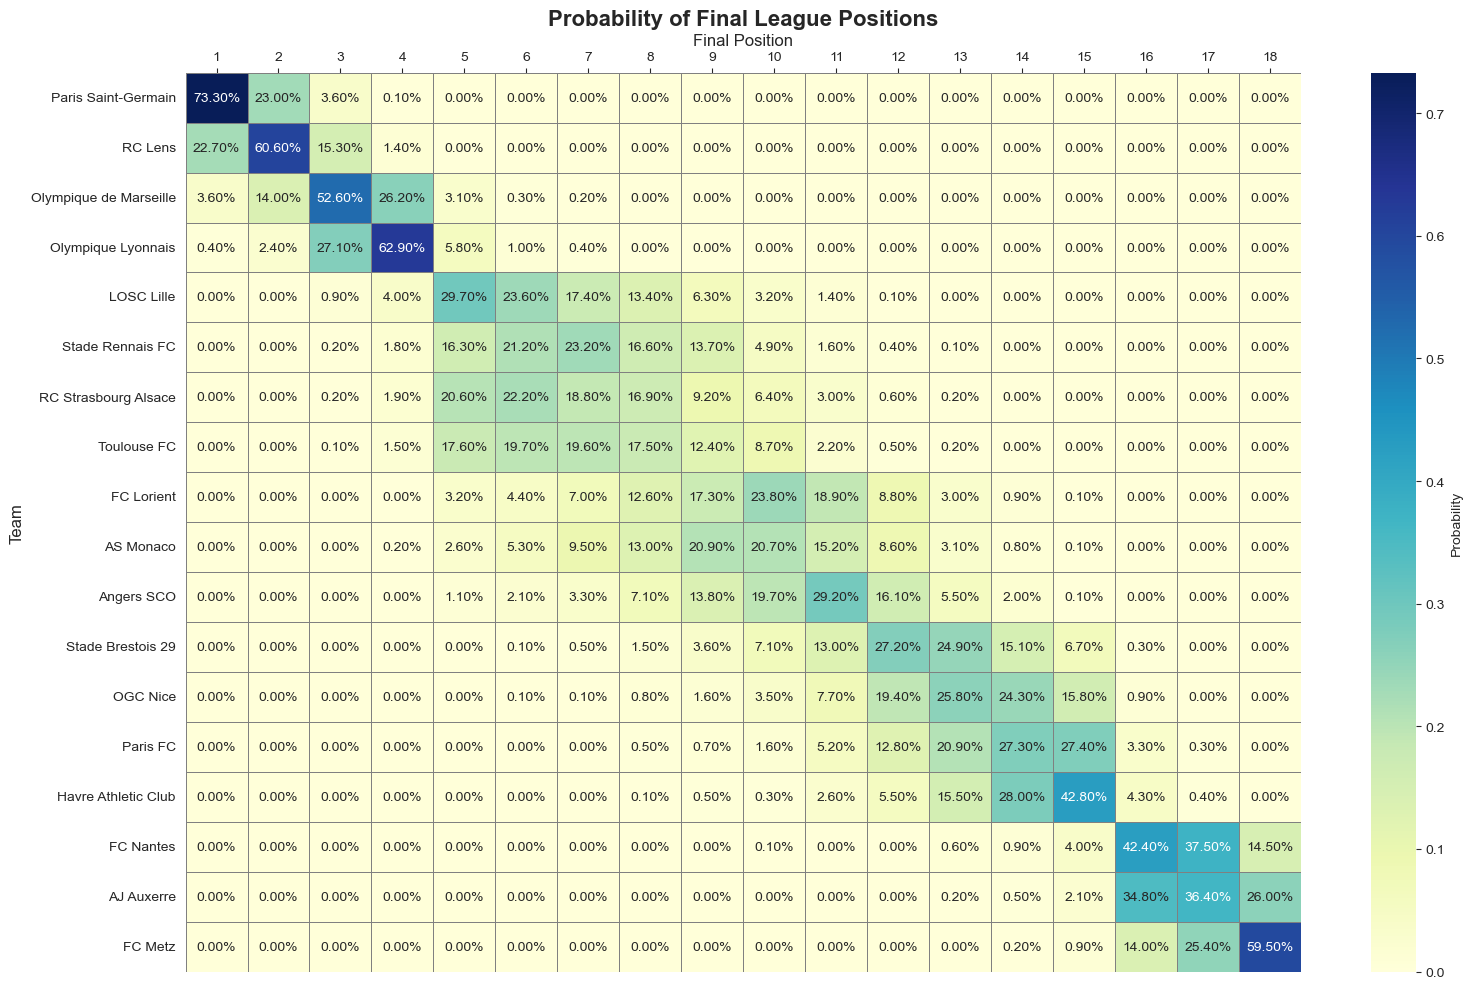

In [16]:
# Import visualization functions
from src.visualization import (
    plot_position_probabilities_heatmap,
    plot_team_position_distribution,
    plot_multiple_teams_distribution,
)

# Create heatmap visualization
plot_position_probabilities_heatmap(position_probs)

## 7. Detailed Team Analysis

Generate detailed statistics for each team's expected final position.

In [17]:
# Generate team statistics report
team_names = current_league_table["Team"].tolist()
team_stats_report = {}

for team in team_names:
    team_stats_report[team] = get_team_final_position_stats(position_probs, team)

# Create a DataFrame for better visualization
stats_df = pd.DataFrame(team_stats_report).T
stats_df = stats_df.sort_values("most_likely_position")

print("Team Final Position Statistics:\n")
print(stats_df)

Team Final Position Statistics:

                        most_likely_position  most_likely_prob  mean_position  \
Paris Saint-Germain                      1.0             0.733           1.31   
RC Lens                                  2.0             0.606           1.95   
Olympique de Marseille                   3.0             0.526           3.13   
Olympique Lyonnais                       4.0             0.629           3.76   
LOSC Lille                               5.0             0.297           6.43   
RC Strasbourg Alsace                     6.0             0.222           7.01   
Toulouse FC                              6.0             0.197           7.21   
Stade Rennais FC                         7.0             0.232           7.08   
AS Monaco                                9.0             0.209           9.35   
FC Lorient                              10.0             0.238           9.52   
Angers SCO                              11.0             0.292          10.3

## 8. Top Teams Analysis

Compare position distributions for top teams.

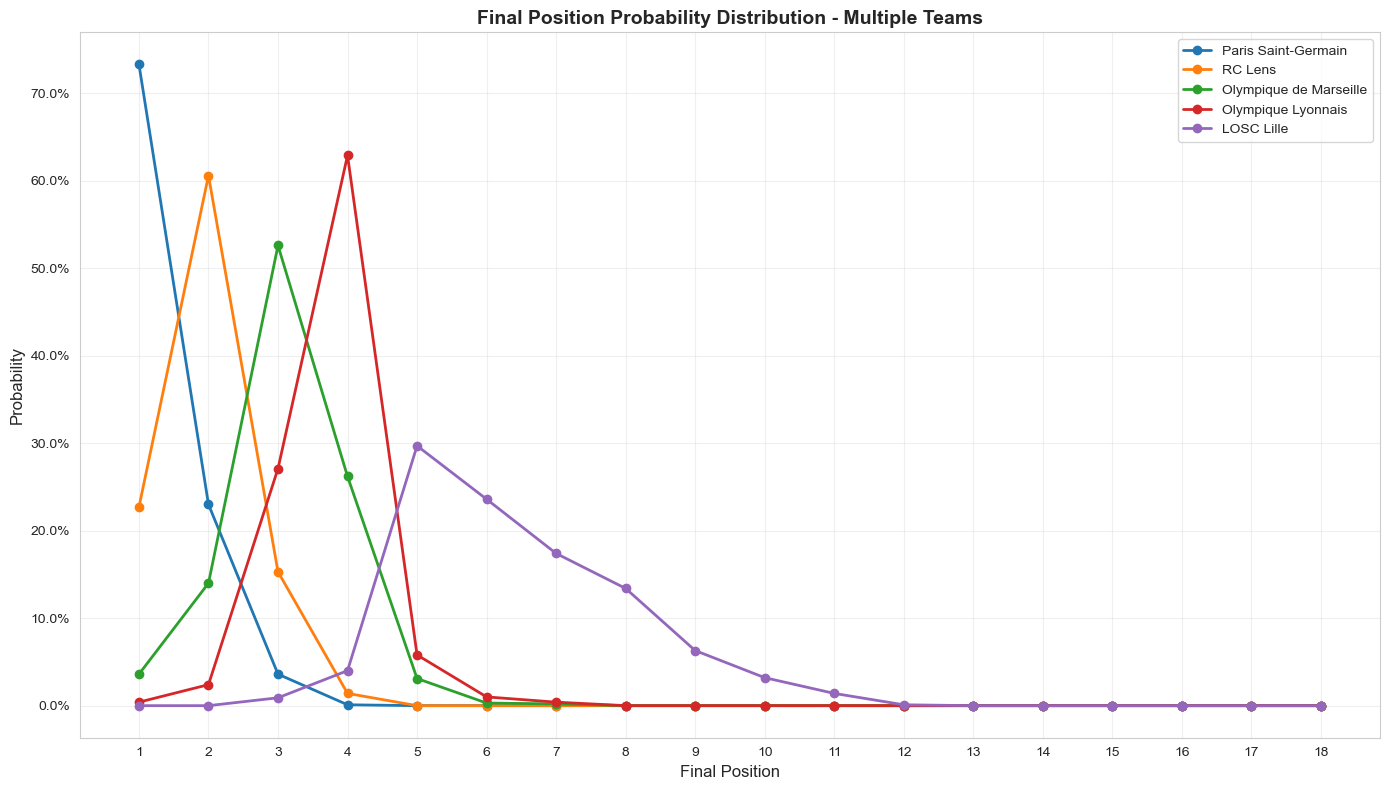

In [18]:
# Analyze top 5 teams
top_5_teams = current_league_table.head(5)["Team"].tolist()

plot_multiple_teams_distribution(position_probs, top_5_teams)

## 9. Summary and Conclusions

Key findings from the Monte Carlo simulation.

In [19]:
# Summary statistics
print(f"League: {config['league']['name']}")
print(f"Season: {config['league']['current_season']}")
print(f"Monte Carlo Simulations: {n_simulations}")
print()

print("Championship Probabilities (Top 3):")
for i, team in enumerate(stats_df.head(3).index, 1):
    prob = position_probs.loc[team, 1]
    print(f"{i}. {team}: {prob:.2%}")

print("\nRelegation Zone Probabilities (Bottom 3):")
n_positions = len(position_probs.columns)
for team in stats_df.tail(3).index:
    prob_bottom_3 = position_probs.loc[team, n_positions - 2 : n_positions].sum()
    print(f"{team}: {prob_bottom_3:.2%}")

League: Ligue 1
Season: 2025
Monte Carlo Simulations: 1000

Championship Probabilities (Top 3):
1. Paris Saint-Germain: 73.30%
2. RC Lens: 22.70%
3. Olympique de Marseille: 3.60%

Relegation Zone Probabilities (Bottom 3):
FC Nantes: 94.40%
AJ Auxerre: 97.20%
FC Metz: 98.90%
